In [3]:
# Data
import numpy as np
import pandas as pd
import glob
import os

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
# combine all datsets into one big dataset and save to parquet

path = r'' 

all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

#--- data cleaning ---

# drop row number column
df = df.drop("No", axis=1)

# replace column names
def change_column_name(name):
    name = name.lower()
    
    if name == 'pm2.5':
        name = "pm25"
    if name == "temp":
        name = "temperatur"
    if name == "pres":
        name = "pressure"
    if name == "dewp":
        name = "dew_point"
    if name == "wd":
        name = "wind_direction"
    if name == "wspm":
        name = "wind_speed"
        
    return name

column_names = list(df.columns)
column_names = [change_column_name(x) for x in column_names]
df.columns = column_names

df.to_parquet("prsa_data.parquet")

In [52]:
df.columns

Index(['year', 'month', 'day', 'hour', 'pm25', 'pm10', 'so2', 'no2', 'co',
       'o3', 'temperatur', 'pressure', 'dew_point', 'rain', 'wind_direction',
       'wind_speed', 'station'],
      dtype='object')

# EDA - air quality dataset

In [5]:
weather = pd.read_csv("weather.csv")

In [6]:
weather.head()

,date,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,DewPointFarenheit,DewPointCelsius,RelativeHumidity,WindSpeed,WindDirection,StationPressure,Altimeter,WetBulbCelsius
0,1/1/2010 0:00,10.0,16,-9,13,7,-14,67,7,130,21.65,30.35,-10.3
1,1/1/2010 1:00,10.0,16,-9,13,7,-14,67,5,150,21.64,30.34,-10.3
2,1/1/2010 2:00,10.0,16,-9,13,7,-14,67,5,190,21.65,30.35,-10.3
3,1/1/2010 3:00,10.0,16,-9,13,7,-14,67,7,180,21.65,30.35,-10.3
4,1/1/2010 4:00,10.0,16,-9,14,9,-13,74,6,120,21.64,30.34,-10.0


In [8]:
# Description of the columns
print('Data: '+'\x1b[1;31m'+'Weather'+'\x1b[0m'+ ", nrows: {}, ncols: {}".format(aq.shape[0],aq.shape[1]))
print("\033[1m\033[4m\033[95m{:<27} :  {:<7}  {:<50} |  {:>9} {:>9} {:>9} {:>10} {:>10} ({:>4}%)\033[0m".format("column", "type", "samples", "Mean", "Median", "Min", "Max", "Nans", "Nans"))
for column in weather.columns:
    
    column_type = str(weather.dtypes[column])
    
    samples = weather[column].dropna().sample(10).tolist()
    if column_type == "object":
        samples = ["'"+value+"'" for value in samples]
        samples = "  ".join([str(value) for value in samples])[:50]
    else:
        samples = "  ".join([str(round(value,2)) for value in samples])[:50]
    
    mean = "-"
    median = "-"
    mini = "-"
    maxi = "-"
    if column_type != "object":
        mean = round(weather[column].mean(),2)
        median = round(weather[column].median(),2)
        mini = round(weather[column].min(),2)
        maxi = round(weather[column].max(),2)
    
    nans_perc = round(weather[column].isnull().sum() * 100 / len(weather[column]),1)
    nans = weather[column].isnull().sum()
    
    out = "{:<27} :  {:<7}  {:<50} |  {:>9} {:>9} {:>9} {:>10} {:>10} ({}%)".format(column, column_type, samples, str(mean), str(median), str(mini), str(maxi), nans, nans_perc)
    print(out)

Data: Weather, nrows: 35064, ncols: 13
column                      :  type     samples                                            |       Mean    Median       Min        Max       Nans (Nans%)
date                        :  object   '2/10/2011 13:00'  '2/14/2010 19:00'  '1/2/2011 14 |          -         -         -          -          0 (0.0%)
Visibility                  :  float64  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10 |       9.39      10.0       0.0       10.0          0 (0.0%)
DryBulbFarenheit            :  int64    45  21  45  54  32  79  32  50  50  27             |      42.98      43.0       -15         86          0 (0.0%)
DryBulbCelsius              :  int64    5  -2  16  11  12  3  1  14  13  2                 |       6.12       6.0       -26         30          0 (0.0%)
WetBulbFarenheit            :  int64    21  24  50  13  41  49  37  30  22  31             |      33.72      33.0       -16         61          0 (0.0%)
DewPointFarenheit           :  int64    52

In [ ]:
fig, axs = plt.subplots(4, 4)
fig.set_figheight(20)
fig.set_figwidth(20)

colors = plt.rcParams["axes.prop_cycle"]()

for i, ax in enumerate(fig.axes):
        
        if i < len(weather.columns):
            
            # get column name
            column_name = weather.columns[i]
            print("Creating column {}/{} - {}".format(i, len(weather.columns), column_name), end="\r")
            
            # Extract data
            series = weather[column_name].dropna()
            
            # Create subplot
            color = next(colors)["color"]
            
            ax.hist(series, density=True, bins=100, color= color, range=(series.min(), series.max()))
            ax.set_title(column_name+" (min:{} max:{} n={})".format(series.min(),series.max(), series.count()))

            
fig.tight_layout()        
#fig.savefig("../master-thesis/figures/column_distribution.png")

In [82]:
# Columns with highest missing values
nans_in_column = {}
for column in aq.columns:
    
    nans_perc = round(aq[column].isnull().sum() * 100 / len(aq[column]),1)
    nans = aq[column].isnull().sum()
    
    nans_in_column[column] = nans_perc

nans_in_column = {k: v for k, v in sorted(nans_in_column.items(), key=lambda item: item[1])}

for key, value in nans_in_column.items():
    print("{:>26} - {}%".format(key,value))

                      year - 0.0%
                     month - 0.0%
                       day - 0.0%
                      hour - 0.0%
                   station - 0.0%
                temperatur - 0.1%
                  pressure - 0.1%
                 dew_point - 0.1%
                      rain - 0.1%
                wind_speed - 0.1%
            wind_direction - 0.4%
                      pm10 - 1.5%
                      pm25 - 2.1%
                       so2 - 2.1%
                       no2 - 2.9%
                        o3 - 3.2%
                        co - 4.9%


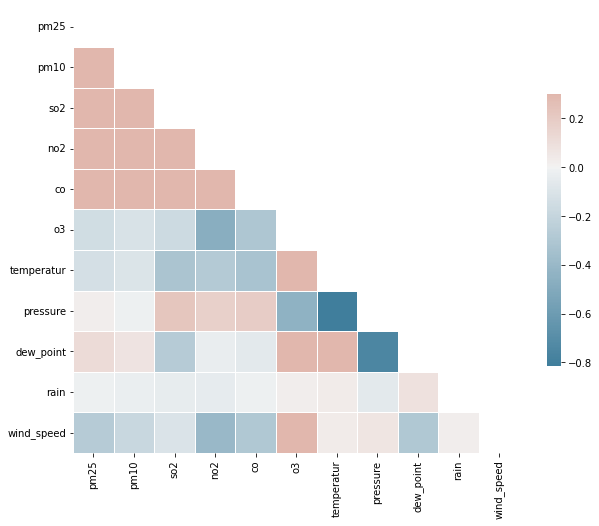

In [93]:
# correlation between variables
corr = aq.iloc[:,4:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

- **temperature** and **pressure** have a high negative correlation
- **dewpoint** and **pressure** have a high negative correlation
- **chemical measurements** have a slight positive correlation with each other 